# V1模型仿真可视化和探索性分析

这个notebook提供了V1模型仿真结果的可视化和交互式分析工具。

基于Training-data-driven-V1-model-test工具包

In [1]:
# 导入必要的库
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle as pkl
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# 设置图形显示参数
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False

# 添加上级目录到Python路径
sys.path.append(os.path.dirname(os.path.abspath('')))

# 导入工具包模块
from test_simulation import V1SimulationTester 
from interactive_test import InteractiveV1Tester
from load_sparse import load_network, load_input, set_laminar_indices
from models import BillehColumn
import classification_tools

d:\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


## 参数分析总结

通过上述可视化，我们可以比较GLIF网络和Allen V1网络的神经元参数差异：

1. **神经元类型数量**：两个网络可能有不同数量的神经元类型
2. **参数范围**：各个生物物理参数的取值范围可能存在差异
3. **参数分布**：参数在不同神经元类型间的分布模式

这种比较有助于理解不同V1模型实现之间的差异和相似性。

## 0. 测试单个神经元仿真

In [1]:
from neuron_response_analysis import (
    simulate_neuron_response, 
    plot_single_response, 
    analyze_current_response
)

d:\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


正在模拟神经元类型: i1Htr3a (索引 0), 电流强度: 0.2 nA
> Recurrent synapses 1
> Input synapses 0


d:\MICrONS\Training-data-driven-V1-model-test\Chen_package_test\neuron_response_analysis.py:167: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "|k" (-> color='k'). The keyword argument will take precedence.
  ax2.plot(time[spike_idx], spike_voltage, '|k', markersize=10, color='red')


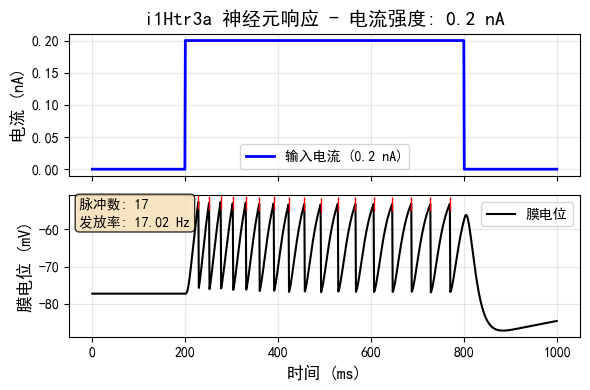

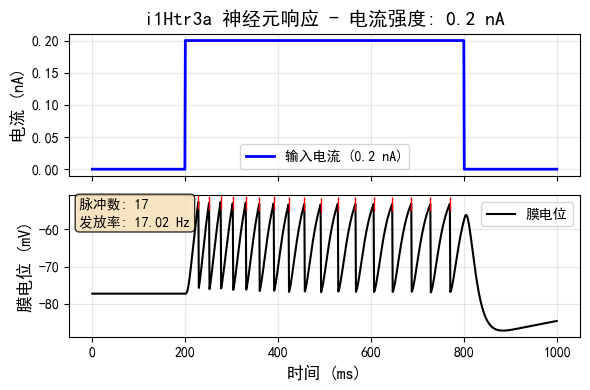

In [2]:
# 参数设置
neuron_type = 'i1Htr3a'
current_amplitude = 0.2  # nA

# 运行仿真
time, current, voltage, spikes = simulate_neuron_response(
    target_neuron_type=neuron_type,
    platform_current=current_amplitude
)

# 绘制结果
plot_single_response(
    time, current, voltage, spikes, 
    neuron_type, current_amplitude,
    show_plot=True
)

In [ ]:
neuron_type = 'i1Htr3a'
current_amplitudes = [0, 0.05, 0.08, 0.09, 0.1, 0.11, 0.12, 0.14, 0.17, 0.2, 0.25]

# 运行分析
results = analyze_current_response(
    neuron_type=neuron_type,
    current_amplitudes=current_amplitudes
)


处理电流强度: 0 nA (1/11)
正在模拟神经元类型: i1Htr3a (索引 0), 电流强度: 0 nA
> Recurrent synapses 1
> Input synapses 0

处理电流强度: 0.05 nA (2/11)
正在模拟神经元类型: i1Htr3a (索引 0), 电流强度: 0.05 nA
> Recurrent synapses 1
> Input synapses 0


## 1. 加载网络和运行基本仿真

In [2]:
# 修改input_dat.pkl文件，将第一个元素（lgn）的输入spike和权重都置为0
import pickle as pkl
import numpy as np

def delete_data(input_file_path, type='lgn'):
    # 加载input_dat.pkl文件
    with open(input_file_path, 'rb') as f:
        input_data = pkl.load(f)

    if type == 'lgn':
        # 获取第一个元素（lgn）
        lgn_nodes_info, lgn_edges_info = input_data[0]
        # 1. 清空所有LGN spike
        print("\n正在清空LGN spike数据...")
        lgn_nodes_info['spikes'] = [np.array([]) for _ in lgn_nodes_info['spikes']]
        # 2. 将所有LGN权重置为0
        print("正在将LGN权重置为0...")
        for edge_group in lgn_edges_info:
            edge_group['params']['weight'] = np.zeros_like(edge_group['params']['weight'])
        # 更新数据
        input_data[0] = (lgn_nodes_info, lgn_edges_info)

    elif type == 'bkg':
        # 获取第一个元素（lgn）
        bkg_nodes_info, bkg_edges_info = input_data[1]
        # 1. 清空所有LGN spike
        print("\n正在清空BKG spike数据...")
        bkg_nodes_info['spikes'] = [np.array([]) for _ in bkg_nodes_info['spikes']]
        # 2. 将所有LGN权重置为0
        print("正在将BKG权重置为0...")
        for edge_group in bkg_edges_info:
            edge_group['params']['weight'] = np.zeros_like(edge_group['params']['weight'])
        # 更新数据
        input_data[1] = (bkg_nodes_info, bkg_edges_info)

    # 保存修改后的数据
    with open(input_file_path, 'wb') as f:
        pkl.dump(input_data, f)

delete_data(input_file_path='Allen_V1_param/input_dat.pkl', type='lgn')
delete_data(input_file_path='Allen_V1_param/input_dat.pkl', type='bkg')


正在清空LGN spike数据...
正在将LGN权重置为0...

正在清空BKG spike数据...
正在将BKG权重置为0...


In [2]:
# 创建测试器并加载网络
tester = InteractiveV1Tester(
    data_dir='Allen_V1_param',
    simulation_time=500,  # 500ms用于快速测试
    dt=1,
    seed=42
)

# 加载网络
print("正在加载网络...")
network, input_populations = tester.load_network_and_input(
    n_neurons=1000,  # 使用2000个神经元
    core_only=True
)

# 准备仿真
cell, lgn_input, bkg_input = tester.prepare_simulation(network, input_populations)

初始化V1模型仿真测试器...
数据目录: Allen_V1_param
仿真时长: 500 ms
时间步长: 1 ms
正在加载网络...

加载网络结构...
> Number of Neurons: 1000
> Number of Synapses: 5678
网络加载完成：1000个神经元，5678个突触连接

加载输入数据...
LGN输入：17400个输入神经元
背景输入：1个输入神经元

创建BillehColumn神经元模型（外部背景输入模式）...
> Recurrent synapses 5678
> Input synapses 14681


In [3]:
# 运行仿真
simulation_results = tester.run_simulation(cell, lgn_input, bkg_input, batch_size=1, use_rnn_layer=True)

运行基于TensorFlow RNN层的神经动力学仿真...
  使用TensorFlow RNN层执行仿真...
  RNN仿真失败: Exception encountered when calling RNN.call().

{{function_node __wrapped__Pack_N_5_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [1,1000] != values[2].shape = [1,2000] [Op:Pack] name: x

Arguments received by RNN.call():
  • sequences=tf.Tensor(shape=(1, 500, 4000), dtype=float32)
  • initial_state=('tf.Tensor(shape=(1, 4000), dtype=float32)', 'tf.Tensor(shape=(1, 1000), dtype=float32)', 'tf.Tensor(shape=(1, 1000), dtype=float32)', 'tf.Tensor(shape=(1, 1000), dtype=float32)', 'tf.Tensor(shape=(1, 1000), dtype=float32)', 'tf.Tensor(shape=(1, 4000), dtype=float32)', 'tf.Tensor(shape=(1, 4000), dtype=float32)')
  • mask=None
  • training=False
  回退到逐时间步仿真方法...
运行神经动力学仿真...
  仿真进度: 0/500 时间步
  仿真进度: 100/500 时间步
  仿真进度: 200/500 时间步
  仿真进度: 300/500 时间步
  仿真进度: 400/500 时间步
仿真完成！耗时: 3.304 秒

仿真统计：
  平均发放率: 0.00 Hz
  活跃神经元比例: 0.00%


In [ ]:
output_h5_path = 'D:\MICrONS\Training-data-driven-V1-model-test\Chen_package_test\simulation_results.h5'
tester.save_spikes_to_h5(
    simulation_results=simulation_results,
    network=network,
    output_file=output_h5_path
)


将仿真结果保存为HDF5格式: D:\MICrONS\Training-data-driven-V1-model-test\Chen_package_test\simulation_results.h5
转换脉冲数据为timestamps和node_ids格式...
总共 98086 个脉冲事件
时间范围: 6.00 - 499.00 ms
涉及神经元: 719 个
神经元ID范围: 20876 - 186593
HDF5文件保存完成: D:\MICrONS\Training-data-driven-V1-model-test\Chen_package_test\simulation_results.h5


'D:\\MICrONS\\Training-data-driven-V1-model-test\\Chen_package_test\\simulation_results.h5'

Plotting 1000 neurons over 500 time bins (500ms)


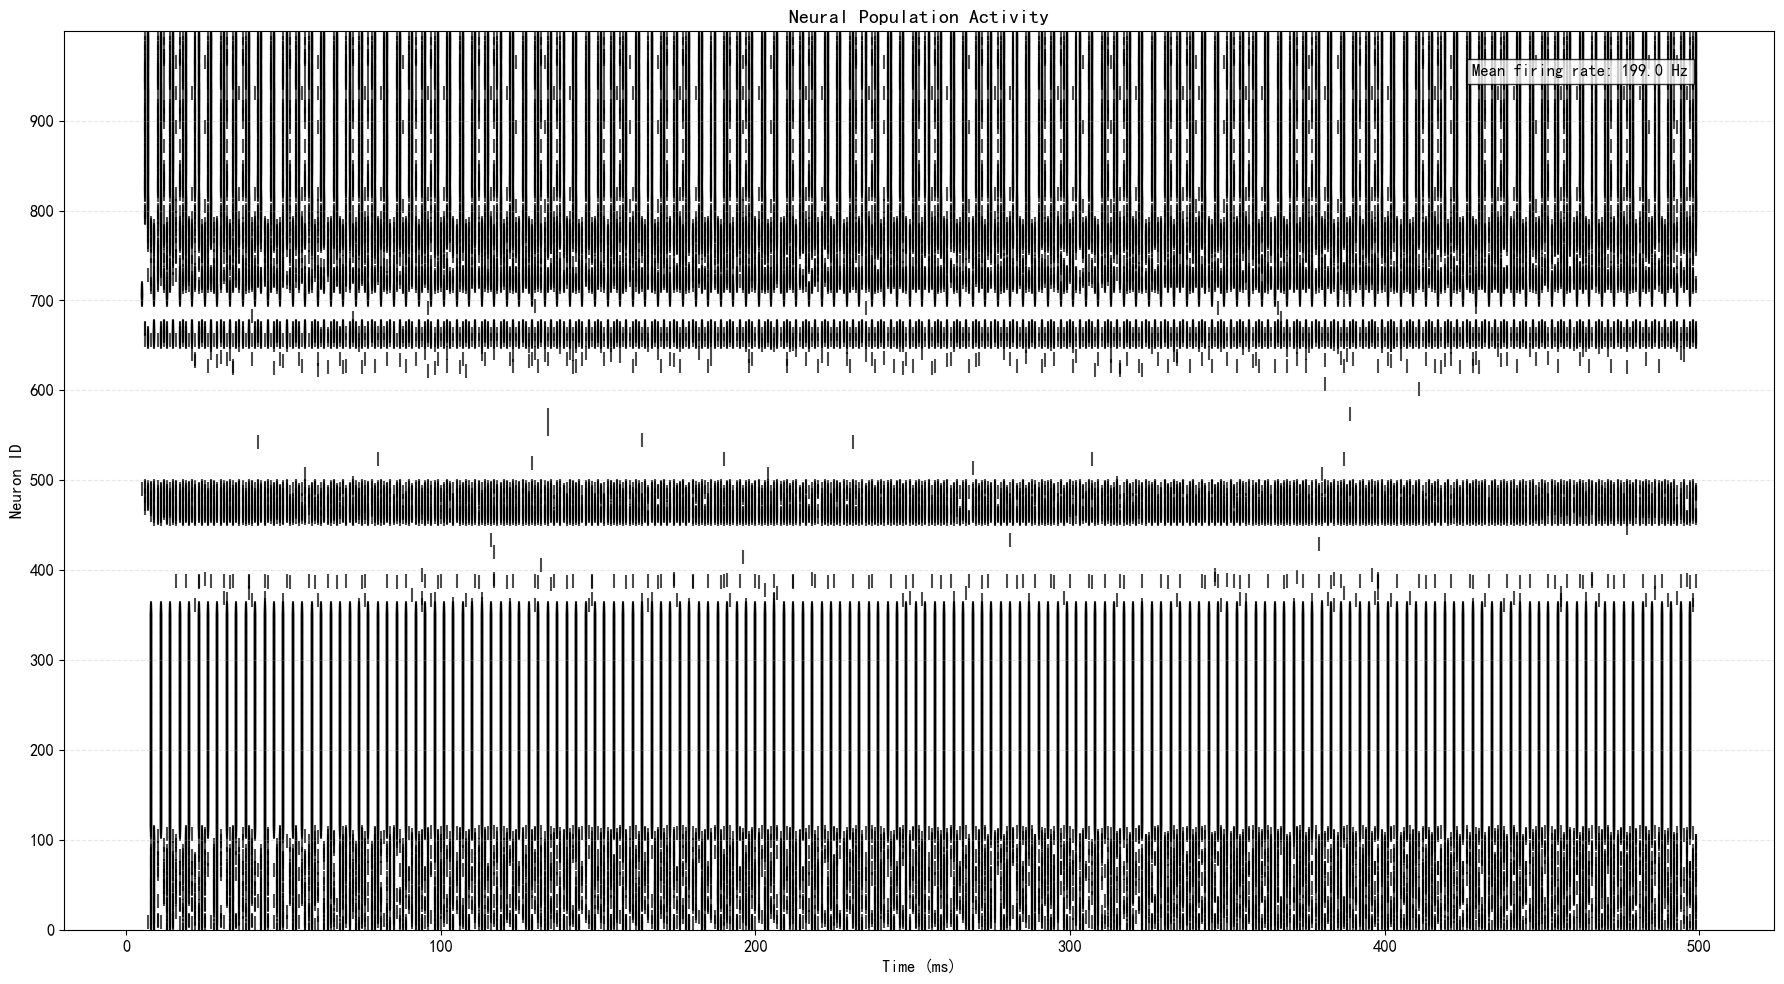

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_raster(spike_train, bin_size=1, title="Neural Raster Plot", 
                xlabel="Time (ms)", ylabel="Neuron ID", figsize=(18,10), 
                color='black', alpha=0.7, show_firing_rate=False):
    """
    绘制神经元脉冲序列的raster plot
    
    参数：
    spike_train -- 2D numpy数组 (神经元数 × 时间点)
    bin_size    -- 时间步长（毫秒）
    title       -- 图表标题
    xlabel      -- x轴标签
    ylabel      -- y轴标签
    figsize     -- 图表尺寸
    color       -- 脉冲点颜色
    alpha       -- 脉冲点透明度
    show_firing_rate -- 是否显示平均发放率
    """
    # 验证输入数据
    if not isinstance(spike_train, np.ndarray) or spike_train.ndim != 2:
        raise ValueError("Input must be a 2D numpy array")
        
    n_neurons, n_bins = spike_train.shape
    print(f"Plotting {n_neurons} neurons over {n_bins} time bins ({n_bins*bin_size}ms)")
    
    # 创建图表
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    # 转换脉冲数据为事件坐标
    neuron_ids, time_points = np.where(spike_train > 0)
    
    # 绘制脉冲序列
    ax.scatter(
        time_points * bin_size, 
        neuron_ids,
        marker='|', 
        s=100,  # 控制标记大小
        c=color, 
        alpha=alpha
    )
    
    # 设置坐标轴
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(-0.5, n_neurons - 0.5)  # 为神经元ID留出空间
    
    # 优化刻度显示
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # 添加网格线
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # 可选：显示平均发放率
    if show_firing_rate:
        firing_rates = np.mean(spike_train, axis=1) * (1000 / bin_size)
        mean_rate = np.mean(firing_rates)
        ax.text(0.95, 0.95, 
                f"Mean firing rate: {mean_rate:.1f} Hz",
                transform=ax.transAxes, 
                ha='right',
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


spike_train = simulation_results['spikes'][0].T
n_neurons = spike_train.shape[0]
n_bins = spike_train.shape[1]

# 绘制raster plot
plot_raster(
    spike_train,
    bin_size=1,
    title="Neural Population Activity",
    show_firing_rate=True
)

## 2. 空间组织可视化

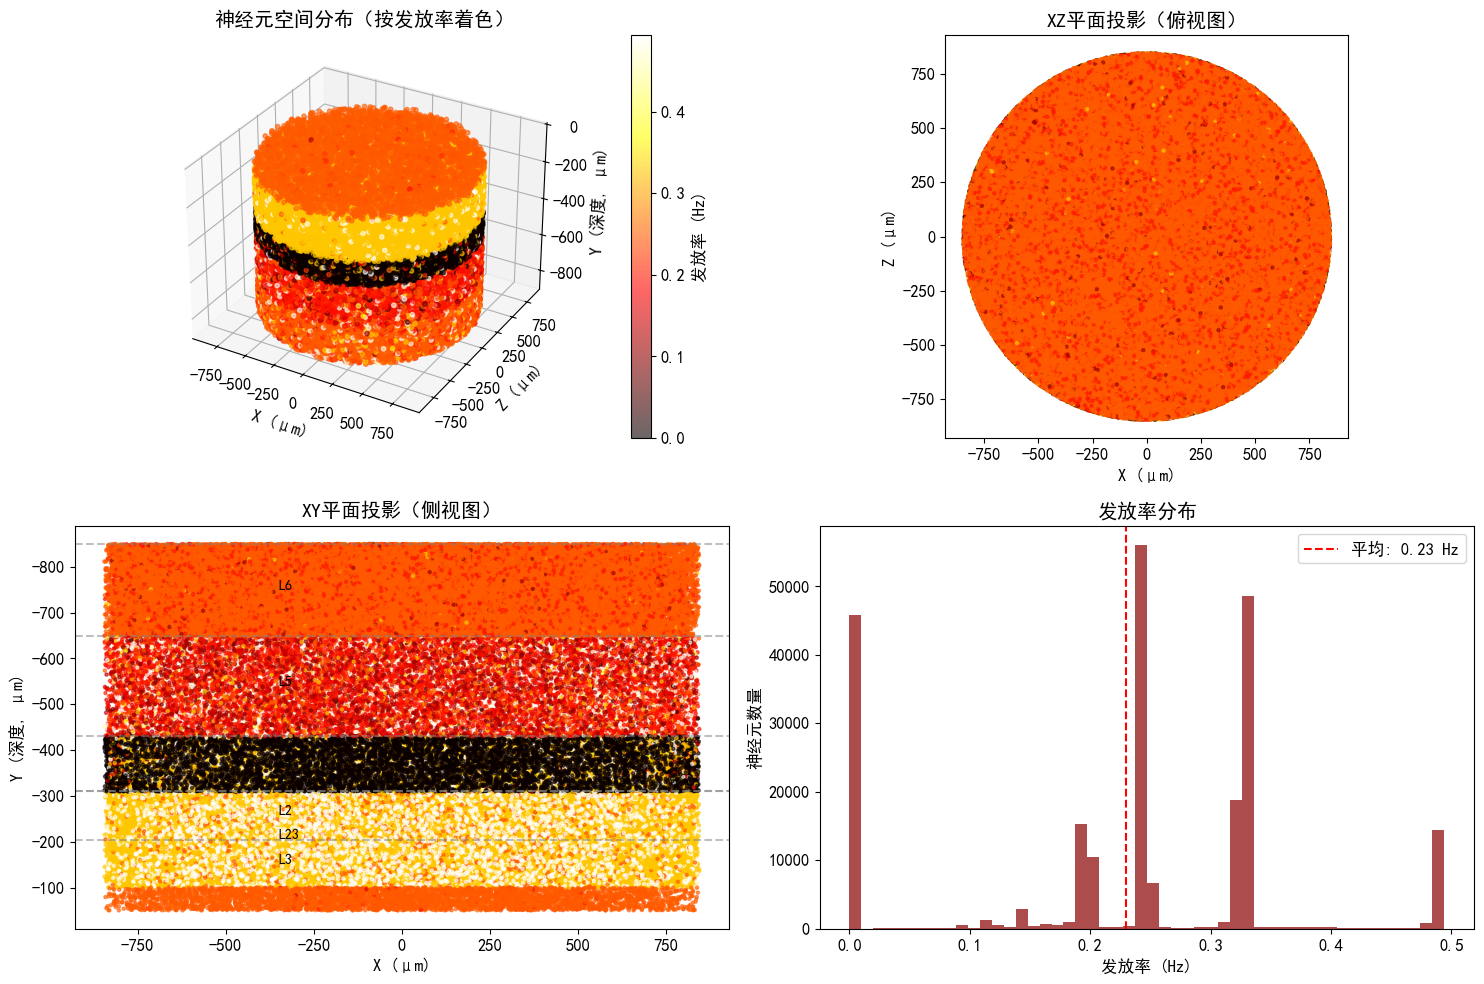

In [ ]:
# 可视化神经元的空间分布和发放率
fig = plt.figure(figsize=(15, 10))

# 创建3D子图
ax1 = fig.add_subplot(221, projection='3d')

# 获取神经元坐标和发放率
x_coords = network['x']
y_coords = network['y']  # 垂直方向（层）
z_coords = network['z']
spike_rates = simulation_results['spike_rates']

# 根据发放率着色
scatter = ax1.scatter(x_coords, z_coords, y_coords, 
                     c=spike_rates, cmap='hot', s=10, alpha=0.6)

ax1.set_xlabel('X (μm)')
ax1.set_ylabel('Z (μm)')
ax1.set_zlabel('Y (深度, μm)')
ax1.set_title('神经元空间分布（按发放率着色）')

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax1, pad=0.1)
cbar.set_label('发放率 (Hz)')

# 2D投影 - XZ平面（俯视图）
ax2 = fig.add_subplot(222)
scatter2 = ax2.scatter(x_coords, z_coords, c=spike_rates, 
                      cmap='hot', s=5, alpha=0.6)
ax2.set_xlabel('X (μm)')
ax2.set_ylabel('Z (μm)')
ax2.set_title('XZ平面投影（俯视图）')
ax2.set_aspect('equal')

# 2D投影 - XY平面（侧视图）
ax3 = fig.add_subplot(223)
scatter3 = ax3.scatter(x_coords, y_coords, c=spike_rates, 
                      cmap='hot', s=5, alpha=0.6)
ax3.set_xlabel('X (μm)')
ax3.set_ylabel('Y (深度, μm)')
ax3.set_title('XY平面投影（侧视图）')
ax3.invert_yaxis()  # 翻转Y轴，使表面在上

# 层级边界
for pop_name, indices in network['laminar_indices'].items():
    if len(indices) > 0 and pop_name.endswith('e'):  # 只显示兴奋性神经元的边界
        y_min = y_coords[indices].min()
        y_max = y_coords[indices].max()
        layer_name = pop_name[:-1]
        ax3.axhline(y_min, color='gray', linestyle='--', alpha=0.5)
        ax3.text(-350, (y_min + y_max) / 2, layer_name, fontsize=10)

# 发放率直方图
ax4 = fig.add_subplot(224)
ax4.hist(spike_rates, bins=50, color='darkred', alpha=0.7)
ax4.set_xlabel('发放率 (Hz)')
ax4.set_ylabel('神经元数量')
ax4.set_title('发放率分布')
ax4.axvline(np.mean(spike_rates), color='red', linestyle='--', 
           label=f'平均: {np.mean(spike_rates):.2f} Hz')
ax4.legend()

plt.tight_layout()
plt.show()

## 3. 特定神经元群体的详细分析

按层筛选 L2e: 27990 个神经元
最终选择: 27990 个神经元


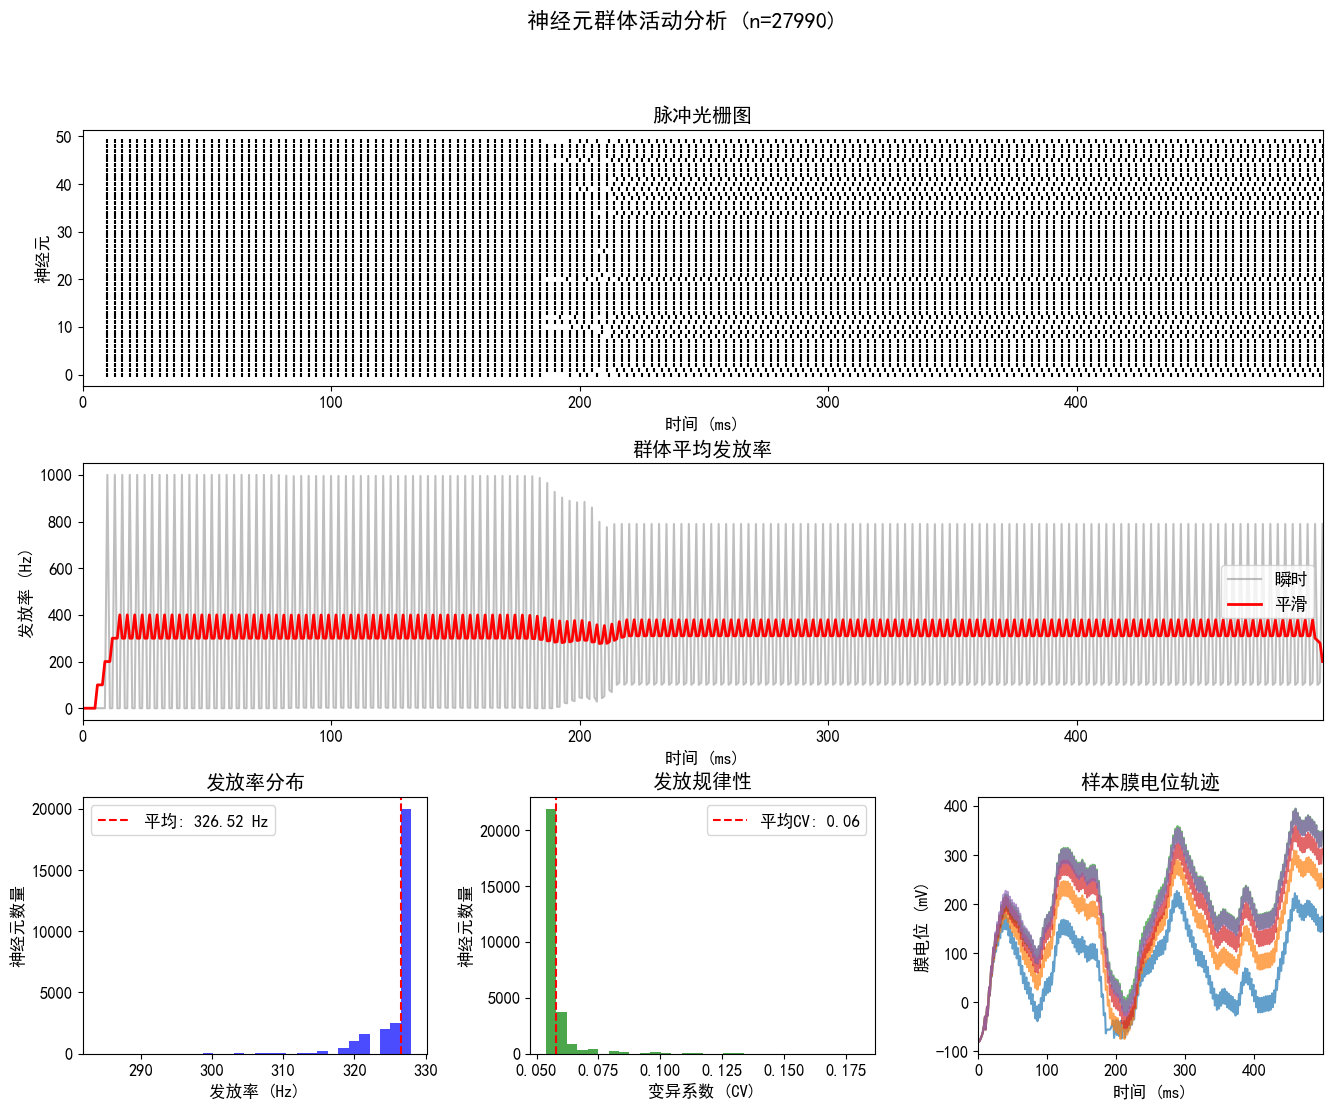

In [ ]:
# 选择L4层兴奋性神经元进行详细分析
selected_indices = tester.select_neurons_by_criteria(
    network,
    layer='L2',
    cell_type='e'
)

# 分析选定的神经元
analysis = tester.analyze_selected_neurons(simulation_results, selected_indices)

# 绘制详细活动图
tester.plot_detailed_activity(simulation_results, selected_indices, analysis)